# Comparación de embeddings

El presente notebook, analizará los embeddings que se pueden obtener al procesar las imágenes con modelos DINOv2 y DINOv3, estos embeddings son proyectados a 3 dimensiones con PCA y visualizados como imagen RGB para facil comprensión.

/home/bllancao/miniconda3/envs/torch271/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


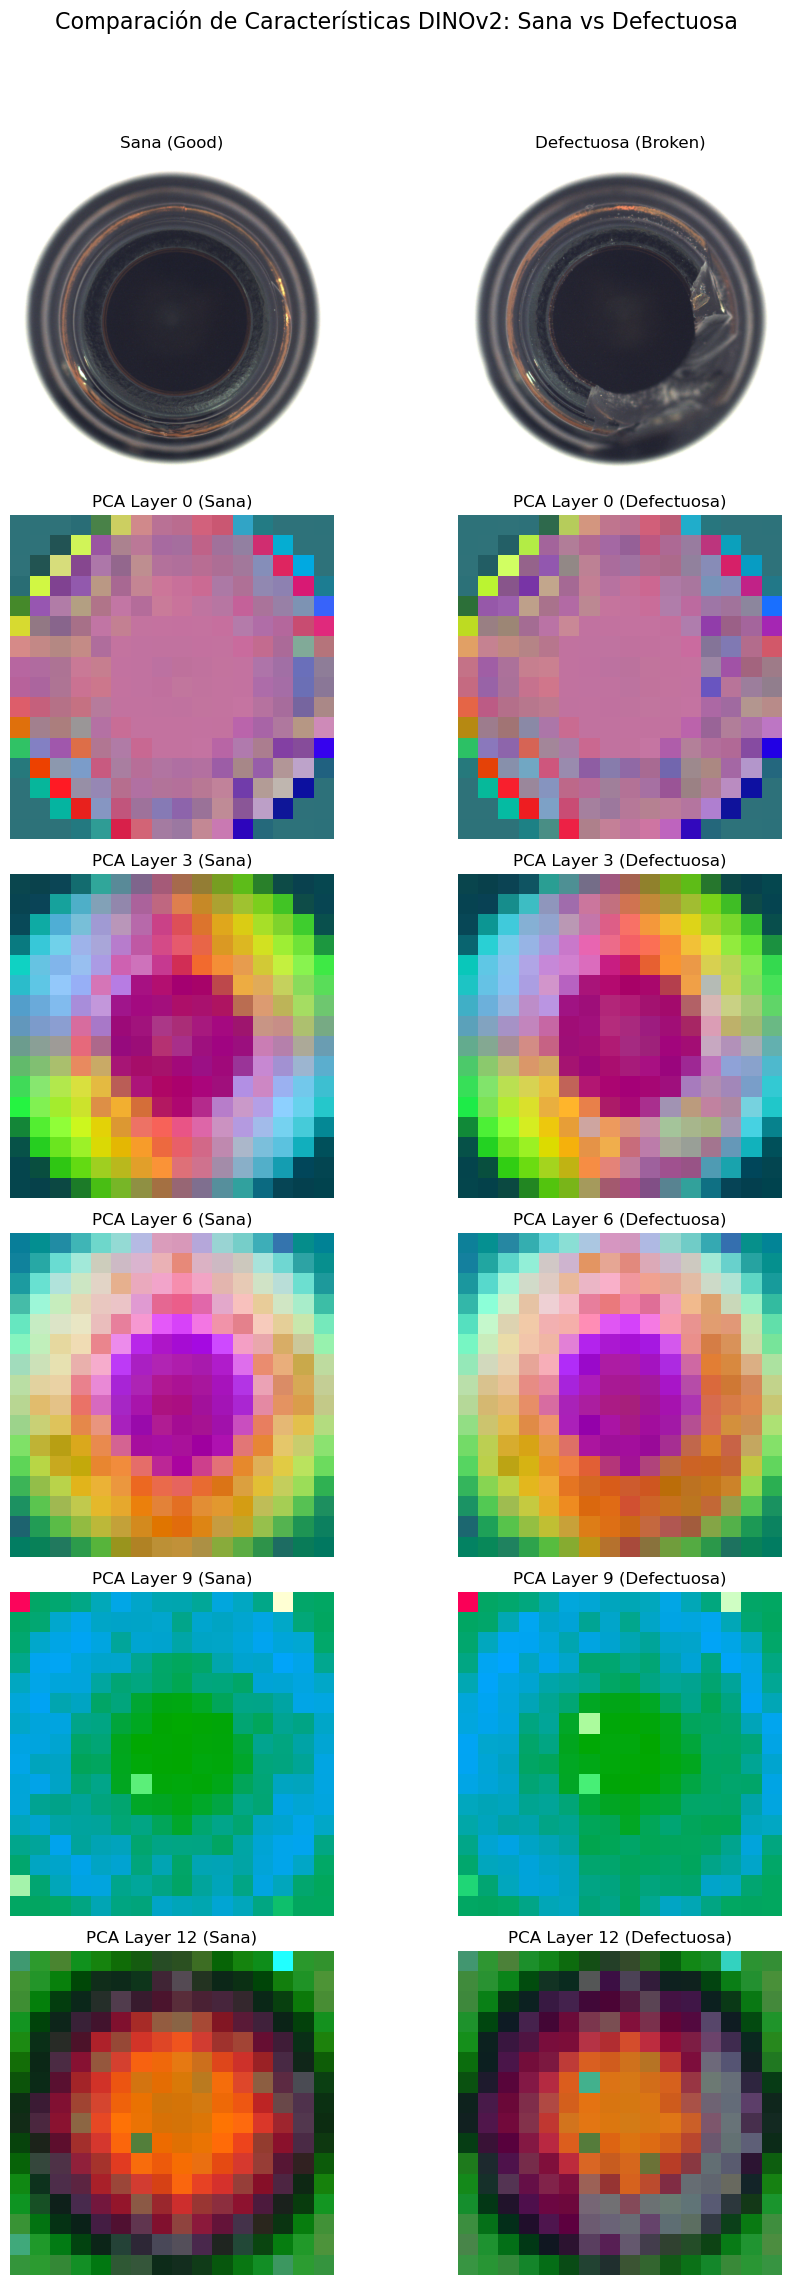

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

# 1. Rutas de las imágenes (Sana vs Defectuosa)
path_good = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/train/good/003.png"
path_broken = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large/000.png"

image_good = Image.open(path_good).convert("RGB")
image_broken = Image.open(path_broken).convert("RGB")

# 2. Cargar modelo
model_path = '/home/bllancao/Portafolio/mvtec_anomaly_detection/models/dinov2-base'
processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# 3. Procesar ambas imágenes
images = [image_good, image_broken]
inputs = processor(images=images, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# hidden_states: lista de tensores [batch=2, seq_len, dim]
all_hidden_states = outputs.hidden_states 

# Dimensiones del mapa (14x14 parches para DINOv2)
h_feat = inputs['pixel_values'].shape[-2] // 14
w_feat = inputs['pixel_values'].shape[-1] // 14

# 4. Visualización Comparativa
num_layers = len(all_hidden_states)
# Mostraremos capas específicas para no saturar, o todas si se prefiere. 
# Vamos a mostrar: Original, Embedding, Capas 3, 6, 9, 12
layers_to_show = [0, 3, 6, 9, 12] 
num_viz = len(layers_to_show) + 1 # +1 por la original

fig, axes = plt.subplots(num_viz, 2, figsize=(10, 4 * num_viz))

# Fila 0: Originales
axes[0, 0].imshow(image_good)
axes[0, 0].set_title("Sana (Good)")
axes[0, 1].imshow(image_broken)
axes[0, 1].set_title("Defectuosa (Broken)")

for i, layer_idx in enumerate(layers_to_show):
    # Obtener estados ocultos de la capa layer_idx para ambas imágenes
    # Shape: [2, seq_len, dim]
    layer_hs = all_hidden_states[layer_idx]
    
    # Extraer tokens espaciales (sin CLS)
    # tokens_good: [seq_len-1, dim], tokens_broken: [seq_len-1, dim]
    tokens_good = layer_hs[0, 1:].detach().cpu().numpy()
    tokens_broken = layer_hs[1, 1:].detach().cpu().numpy()
    
    # Concatenar para que el PCA sea consistente entre ambas imágenes
    combined_tokens = np.vstack([tokens_good, tokens_broken])
    
    pca = PCA(n_components=3)
    pca_combined = pca.fit_transform(combined_tokens)
    
    # Normalizar globalmente para mantener consistencia de color
    pca_min = pca_combined.min(axis=0)
    pca_max = pca_combined.max(axis=0)
    pca_combined = (pca_combined - pca_min) / (pca_max - pca_min + 1e-8)
    
    # Separar resultados
    pca_good = pca_combined[:len(tokens_good)].reshape(h_feat, w_feat, 3)
    pca_broken = pca_combined[len(tokens_good):].reshape(h_feat, w_feat, 3)
    
    # Plotting
    ax_row = i + 1
    axes[ax_row, 0].imshow(pca_good)
    axes[ax_row, 0].set_title(f"PCA Layer {layer_idx} (Sana)")
    axes[ax_row, 1].imshow(pca_broken)
    axes[ax_row, 1].set_title(f"PCA Layer {layer_idx} (Defectuosa)")

for ax in axes.flatten():
    ax.axis('off')

layer_info = "Embedding" if 0 in layers_to_show else ""
plt.suptitle(f"Comparación de Características DINOv2: Sana vs Defectuosa", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Se puede apreciar que para DINOv2 se tienen diferencias sutiles en los embeddings en diferentes capas donde se encuentra la anomalia....
[mejorar]

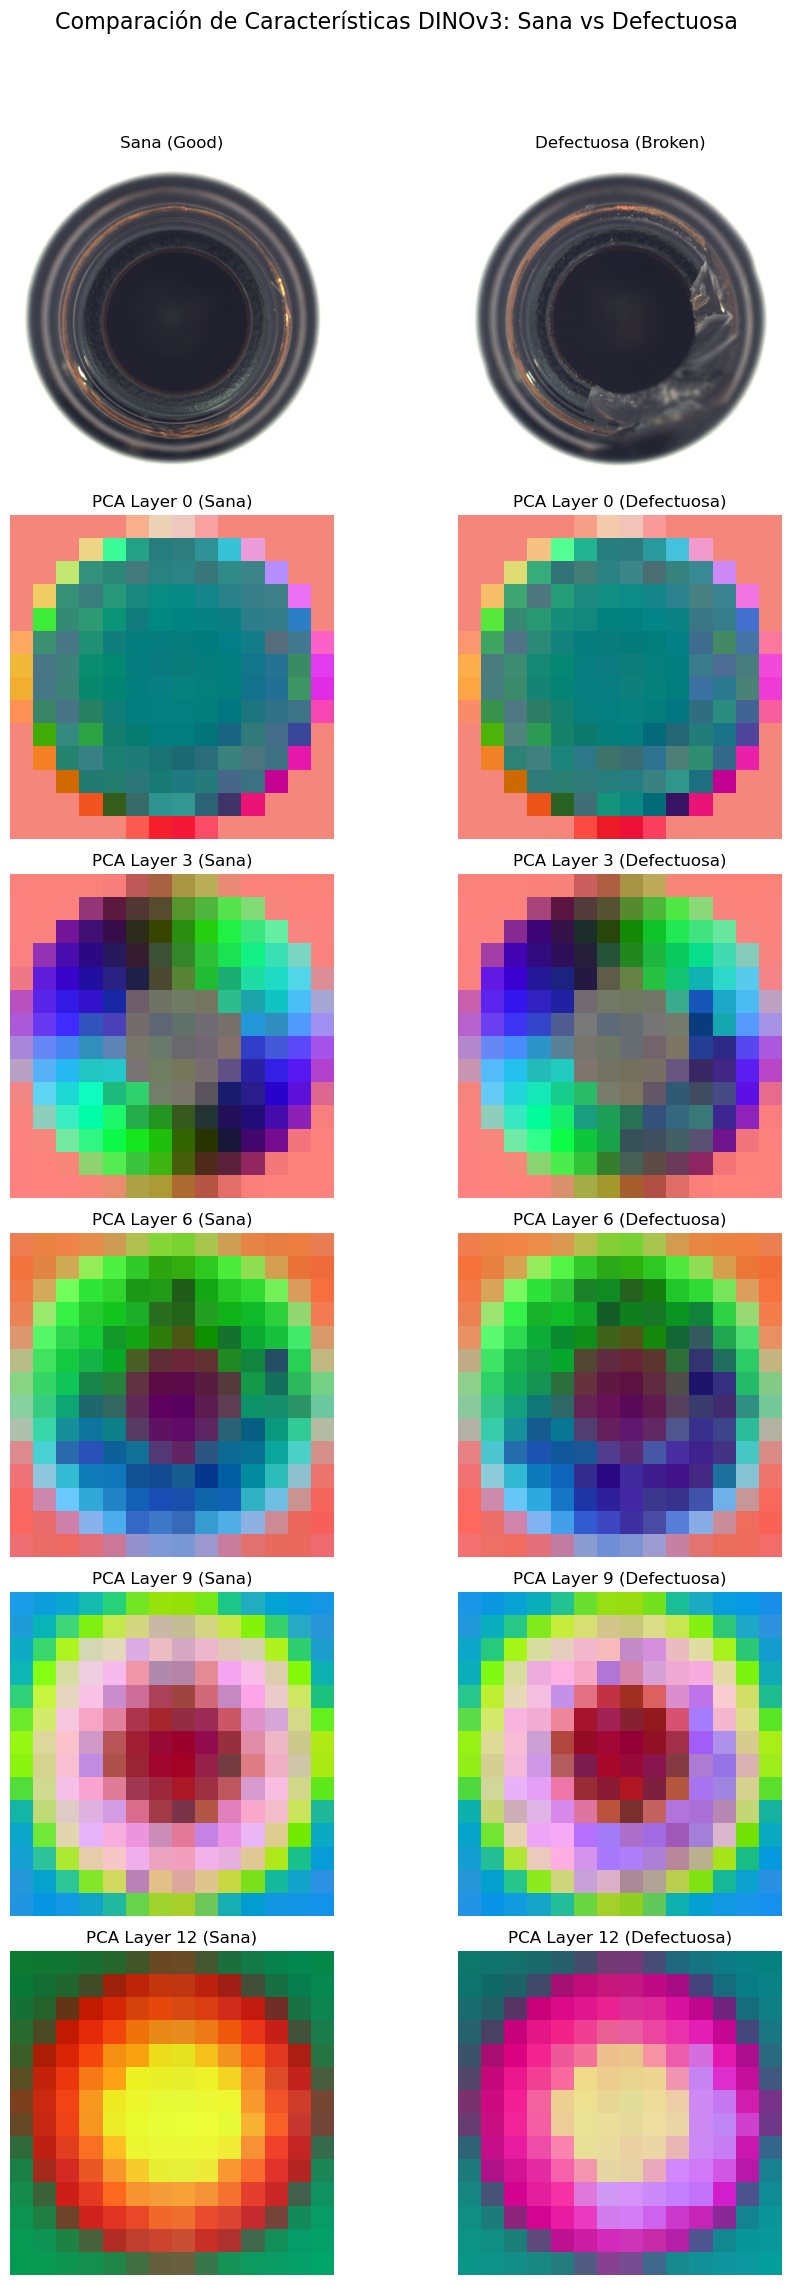

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

# 1. Rutas de las imágenes (Sana vs Defectuosa)
path_good = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/train/good/003.png"
path_broken = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large/000.png"

image_good = Image.open(path_good).convert("RGB")
image_broken = Image.open(path_broken).convert("RGB")

# 2. Cargar modelo
model_path = '/home/bllancao/Portafolio/mvtec_anomaly_detection/models/dinov3-vitb16-pretrain-lvd1689m'
processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

# 3. Procesar ambas imágenes
images = [image_good, image_broken]
inputs = processor(images=images, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# hidden_states: lista de tensores [batch=2, seq_len, dim]
all_hidden_states = outputs.hidden_states 

# Dimensiones del mapa dinámicamente según el patch_size del modelo
patch_size = getattr(model.config, 'patch_size', 16)
h_feat = inputs['pixel_values'].shape[-2] // patch_size
w_feat = inputs['pixel_values'].shape[-1] // patch_size
num_patches = h_feat * w_feat

# 4. Visualización Comparativa
num_layers = len(all_hidden_states)
# Mostraremos capas específicas para no saturar
layers_to_show = [0, 3, 6, 9, 12] 
num_viz = len(layers_to_show) + 1 # +1 por la original

fig, axes = plt.subplots(num_viz, 2, figsize=(10, 4 * num_viz))

# Fila 0: Originales
axes[0, 0].imshow(image_good)
axes[0, 0].set_title("Sana (Good)")
axes[0, 1].imshow(image_broken)
axes[0, 1].set_title("Defectuosa (Broken)")

for i, layer_idx in enumerate(layers_to_show):
    # Obtener estados ocultos de la capa layer_idx
    layer_hs = all_hidden_states[layer_idx]
    
    # Extraer tokens espaciales (los últimos num_patches tokens)
    # Esto ignora automáticamente CLS y tokens de registro si existen
    tokens_good = layer_hs[0, -num_patches:].detach().cpu().numpy()
    tokens_broken = layer_hs[1, -num_patches:].detach().cpu().numpy()
    
    # Concatenar para que el PCA sea consistente
    combined_tokens = np.vstack([tokens_good, tokens_broken])
    
    pca = PCA(n_components=3)
    pca_combined = pca.fit_transform(combined_tokens)
    
    # Normalizar globalmente
    pca_min = pca_combined.min(axis=0)
    pca_max = pca_combined.max(axis=0)
    pca_combined = (pca_combined - pca_min) / (pca_max - pca_min + 1e-8)
    
    # Separar resultados y dar forma 2D
    pca_good = pca_combined[:num_patches].reshape(h_feat, w_feat, 3)
    pca_broken = pca_combined[num_patches:].reshape(h_feat, w_feat, 3)
    
    # Plotting
    ax_row = i + 1
    axes[ax_row, 0].imshow(pca_good)
    axes[ax_row, 0].set_title(f"PCA Layer {layer_idx} (Sana)")
    axes[ax_row, 1].imshow(pca_broken)
    axes[ax_row, 1].set_title(f"PCA Layer {layer_idx} (Defectuosa)")

for ax in axes.flatten():
    ax.axis('off')

plt.suptitle(f"Comparación de Características DINOv3: Sana vs Defectuosa", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

para DINOv3 se tiene una diferencia mas clara .....